In [25]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

#from kaggle_datasets import KaggleDatasets
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
import os

AUTOTUNE = tf.data.AUTOTUNE
RANDOM_SEED = 42
    
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.10.0


In [26]:
#GLOBALS
IMAGE_SIZE = [256, 256]
OUTPUT_CHANNELS = 3
INITIAL_MEAN = 0.0
INITIAL_STD_DEV = 0.02

DATA_DIR = "./data"

MONET_FILENAMES = tf.io.gfile.glob(os.path.join(DATA_DIR + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(os.path.join(DATA_DIR + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


In [27]:
#Image Helper Functions
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    #As the RGB values vary from 0 to 255 inclusive, this next
    #line will alter the values to range from -1 to 1 for training
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

In [28]:
def load_dataset(filenames, labeled = True, ordered = False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls = AUTOTUNE)
    return dataset

monet_ds = load_dataset(MONET_FILENAMES, labeled = True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled = True).batch(1)

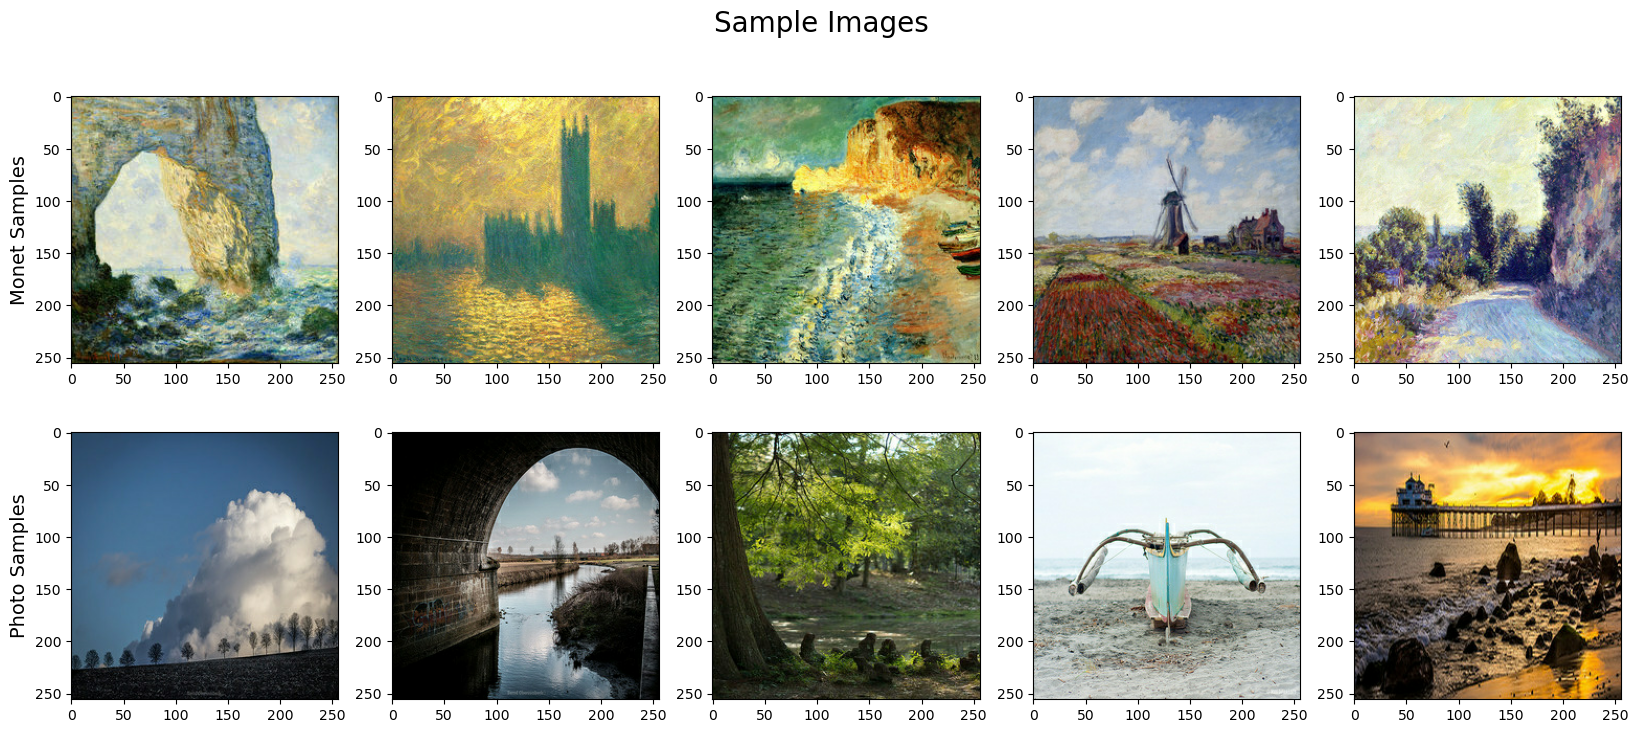

In [29]:
numSamples = 5
def makeSampleRow(row, ds):
    for i, image in enumerate(ds.take(numSamples)):
        #imshow will work with integer values 0 - 255 _or_
        #floats from 0 - 1.  This next line will convert
        #the float values -1 to 1 created in the 
        #_decode_image_ function to a range between 0 - 1
        ax[row, i].imshow(image[0] * 0.5 + 0.5)
        
fig, ax = plt.subplots(2, numSamples, figsize = (20, 8))
fig.suptitle('Sample Images', fontsize = 20)

makeSampleRow(0, monet_ds)
makeSampleRow(1, photo_ds)
ax[0, 0].set_ylabel('Monet Samples', fontsize='14')
ax[1, 0].set_ylabel('Photo Samples',  fontsize='14')

plt.show()

In [30]:
def downsample(filters, size, apply_instancenorm = True):
    initializer = tf.random_normal_initializer(INITIAL_MEAN, INITIAL_STD_DEV)
    gamma_init = keras.initializers.RandomNormal(mean = INITIAL_MEAN, stddev = INITIAL_STD_DEV)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides = 2, padding = 'same',
        kernel_initializer = initializer, use_bias = False)
    )

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer = gamma_init))

    result.add(layers.LeakyReLU())

    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(INITIAL_MEAN, INITIAL_STD_DEV)
    gamma_init = keras.initializers.RandomNormal(mean = INITIAL_MEAN, stddev = INITIAL_STD_DEV)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides = 2, padding = 'same',
        kernel_initializer = initializer, use_bias = False)
    )

    result.add(tfa.layers.InstanceNormalization(gamma_initializer = gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result


In [31]:
def Generator():
    inputs = layers.Input(shape = [*IMAGE_SIZE, 3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm = False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(INITIAL_MEAN, 0.4)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4, strides = 2, 
         padding = 'same', kernel_initializer = initializer, activation = 'tanh'
    ) # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs = inputs, outputs = x)

In [32]:
def Discriminator():
    initializer = tf.random_normal_initializer(INITIAL_MEAN, INITIAL_STD_DEV)
    gamma_init = keras.initializers.RandomNormal(mean = INITIAL_MEAN, stddev = INITIAL_STD_DEV)

    inp = layers.Input(shape = [*IMAGE_SIZE, 3], name = 'input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, 
         use_bias = False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer = gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides = 1,
        kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs = inp, outputs = last)

In [33]:
monet_generator = Generator() # transforms photos to Monet-esque paintings
#photo_generator = Generator() # transforms Monet paintings to be more like photos

monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
#photo_discriminator = Discriminator() # differentiates real photos and generated photos

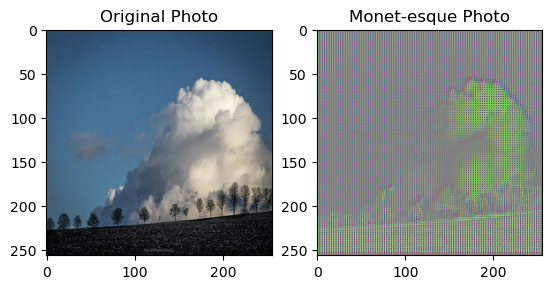

In [34]:
example_photo = next(iter(photo_ds))
to_monet = monet_generator(example_photo)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

In [ ]:
def monet_gen_loss(y_true, y_pred):
    squared_difference = tf.square(y_true - y_pred)
    return tf.reduce_mean(squared_difference, axis=-1)
        

In [62]:
class CycleGan(keras.Model):
    def __init__(self, monet_generator, photo_generator, 
        monet_discriminator, photo_discriminator, lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(self, m_gen_optimizer, p_gen_optimizer, m_disc_optimizer,
        p_disc_optimizer, gen_loss_fn, disc_loss_fn, cycle_loss_fn, identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + \
                self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + \
                self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
                
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + \
                self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {"monet_gen_loss": total_monet_gen_loss, 
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

In [63]:
class CycleGanMonetOnly(keras.Model):
    def __init__(self, monet_generator, photo_generator, 
        monet_discriminator, photo_discriminator, lambda_cycle=10,
    ):
        super(CycleGanMonetOnly, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(self, m_gen_optimizer, p_gen_optimizer, m_disc_optimizer,
        p_disc_optimizer, gen_loss_fn, disc_loss_fn, cycle_loss_fn, identity_loss_fn
    ):
        super(CycleGanMonetOnly, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        self.trainStepCount = 0
        
    @tf.function
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        self.trainStepCount += 1
        
        with tf.GradientTape(persistent = True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training = True)
            cycled_photo = self.p_gen(fake_monet, training = True)

            # monet to photo back to monet
            #fake_photo = self.p_gen(real_monet, training=True)
            #cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training = True)
            #same_photo = self.p_gen(real_photo, training = True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training = True)
            #disc_real_photo = self.p_disc(real_photo, training = True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training = True)
            #disc_fake_photo = self.p_disc(fake_photo, training = True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            #photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
#            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + \
#                self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)
            total_cycle_loss = 0 + \
                self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + \
                self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
                
#            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + \
#                self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)
            total_photo_gen_loss = 0 + total_cycle_loss + \
                0

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
#            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)
            photo_disc_loss = 0

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
#        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
#                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
#        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
#                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

#        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
#                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

#        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
#                                                  self.p_disc.trainable_variables))
        
        if self.trainStepCount % 10 == 0:
            print("monet_gen_loss {0} - photo_gen_loss {1} - monet_disc_loss {2} - photo_disc_loss {3}".format(
                total_monet_gen_loss, total_photo_gen_loss, monet_disc_loss, photo_disc_loss
            )
        )
        return {"monet_gen_loss": total_monet_gen_loss, 
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss,
            "train_step": self.trainStepCount
        }

In [64]:
def generator_loss(generated):
    return tf.keras.losses.BinaryCrossentropy(from_logits = True, 
        reduction = tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

def discriminator_loss(real, generated):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits = True, 
        reduction = tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

    generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits = True, 
        reduction = tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

    return (real_loss + generated_loss) * 0.5

def calc_cycle_loss(real_image, cycled_image, LAMBDA):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss1

def identity_loss(real_image, same_image, LAMBDA):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

In [65]:
#monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)
lr_fn = tf.keras.optimizers.schedules.ExponentialDecay(
    1e-5,
    decay_steps=100,
    decay_rate=0.96,
    staircase=True)

monet_generator_optimizer = tf.keras.optimizers.Adam(learning_rate = lr_fn, beta_1 = 0.5, beta_2 = 0.999, epsilon=0.0001)
photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)

#monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)
monet_discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = lr_fn, beta_1 = 0.5, beta_2 = 0.999, epsilon=0.0001)
photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)

In [66]:
cycle_gan_model = CycleGanMonetOnly(
    monet_generator, photo_generator, monet_discriminator, photo_discriminator
)
cycle_gan_model = CycleGanMonetOnly(
    monet_generator, photo_generator, monet_discriminator, photo_discriminator
)

cycle_gan_model.compile(
    m_gen_optimizer = monet_generator_optimizer,
    p_gen_optimizer = photo_generator_optimizer,
    m_disc_optimizer = monet_discriminator_optimizer,
    p_disc_optimizer = photo_discriminator_optimizer,
    gen_loss_fn = generator_loss,
    disc_loss_fn = discriminator_loss,
    cycle_loss_fn = calc_cycle_loss,
    identity_loss_fn = identity_loss
)

In [69]:
hist = cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds.take(10))),
    epochs = 25, verbose = True
)

Epoch 1/25
10/10 [==============================] - 3s 240ms/step - monet_gen_loss: 8.0481 - photo_gen_loss: 5.5495 - monet_disc_loss: 0.6599 - photo_disc_loss: 0.0000e+00 - train_step: 2.0000
Epoch 2/25
10/10 [==============================] - 2s 238ms/step - monet_gen_loss: 8.0393 - photo_gen_loss: 5.5495 - monet_disc_loss: 0.6588 - photo_disc_loss: 0.0000e+00 - train_step: 2.0000
Epoch 3/25
10/10 [==============================] - 2s 237ms/step - monet_gen_loss: 8.0302 - photo_gen_loss: 5.5496 - monet_disc_loss: 0.6577 - photo_disc_loss: 0.0000e+00 - train_step: 2.0000
Epoch 4/25
10/10 [==============================] - 2s 242ms/step - monet_gen_loss: 8.0211 - photo_gen_loss: 5.5497 - monet_disc_loss: 0.6568 - photo_disc_loss: 0.0000e+00 - train_step: 2.0000
Epoch 5/25
10/10 [==============================] - 2s 247ms/step - monet_gen_loss: 8.0119 - photo_gen_loss: 5.5498 - monet_disc_loss: 0.6558 - photo_disc_loss: 0.0000e+00 - train_step: 2.0000
Epoch 6/25
10/10 [=================

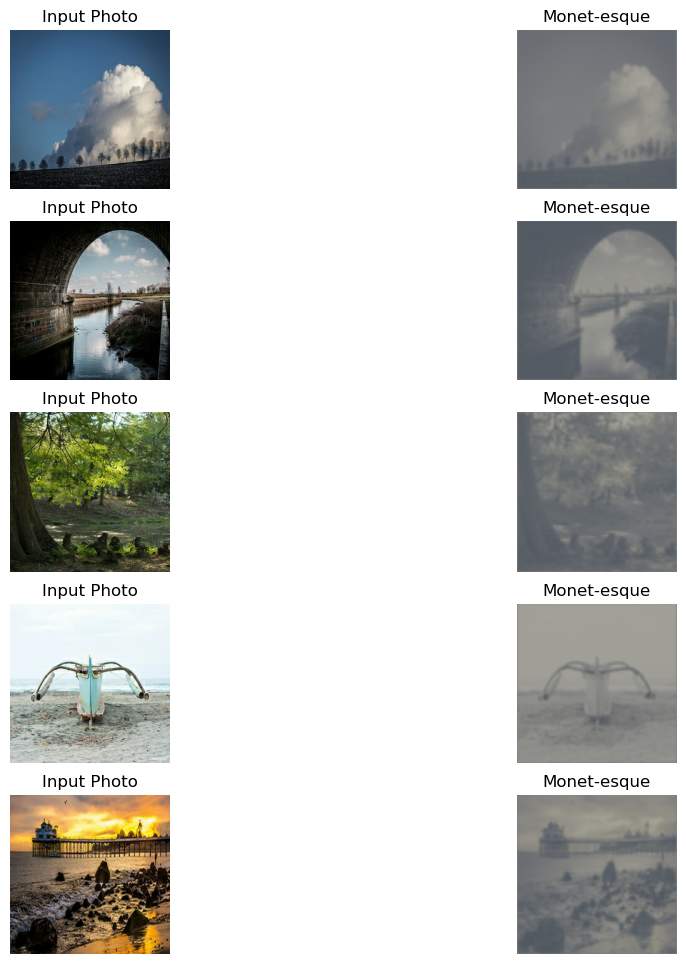

In [70]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training = False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

In [ ]:
import PIL

for i, img in enumerate(photo_ds):
    prediction = monet_generator(img, training = False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("./images/" + str(i) + ".jpg")
